# SARIMA (Seasonal Autoregressive Integrated Moving Average)
A versatile and widely used time series forecasting model. It’s an extension of the non-seasonal ARIMA model, designed to handle data with seasonal patterns. SARIMA captures both short-term and long-term dependencies within the data, making it a robust tool for forecasting. It combines the concepts of autoregressive (AR), integrated (I), and moving average (MA) models with seasonal components.

In [1]:
# @title Tools Imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from google.colab import drive
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score, mean_squared_log_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
import warnings
warnings.filterwarnings('ignore')

In [2]:
# @title GDrive Mount
drive.mount('/content/gdrive/', force_remount=True)
gdrive_path = '/content/gdrive' + '/My Drive/ked/'
os.chdir(gdrive_path)
cwd = os.getcwd()
files = os.listdir(cwd)
print("Files in %r: %s" % (cwd, files))

Mounted at /content/gdrive/
Files in '/content/gdrive/My Drive/ked': ['augusta.csv', 'cleveland.csv', 'youngstown.csv', 'augusta_days.csv', 'augusta_.csv', 'logs.log']


In [3]:
# @title Data Loading
# Read csv to pandas
data = pd.read_csv('youngstown.csv')
# Change datetime format
data['date'] = pd.to_datetime(data['date'], errors='coerce', format='%Y%m')
# Keep only the year and month in the date
data['date'] = data['date'].dt.to_period('M')
# Set date as index for the dataset
data.set_index('date', inplace=True)
# Change column name to 'y' to avoid hard coding when changing features
data = data.rename(columns={'total return unit': 'y'})
# Drop any missing values
data = data.dropna()
# Split data into training and testing sets
train_size = int(0.8 * len(data))
# First 80% for training and last 20% for testing
train_data, test_data = data[:train_size], data[train_size:]
# Verify that the split is correct by checking the shapes and continuity
print(f"Training Data Shape: {train_data.shape}")
print(f"Testing Data Shape: {test_data.shape}")
print(f"Total Data Shape: {data.shape}")
print(f"Training Set First Date: {train_data.index[0]}")
print(f"Training Set Last Date: {train_data.index[-1]}")
print(f"Test Set First Date: {test_data.index[0]}")
print(f"Test Set Last Date: {test_data.index[-1]}")
print(f"\nSample Training Data (Raw):\n", train_data['y'].head())
print(f"\nSample Test Data (Raw):\n", test_data['y'].head())

Training Data Shape: (48, 10)
Testing Data Shape: (12, 10)
Total Data Shape: (60, 10)
Training Set First Date: 2019-01
Training Set Last Date: 2022-12
Test Set First Date: 2023-01
Test Set Last Date: 2023-12

Sample Training Data (Raw):
 date
2019-01    3179
2019-02    3017
2019-03    2987
2019-04    3106
2019-05    3447
Freq: M, Name: y, dtype: int64

Sample Test Data (Raw):
 date
2023-01    3652
2023-02    3416
2023-03    3883
2023-04    3715
2023-05    3955
Freq: M, Name: y, dtype: int64


In [4]:
# @title Available Features
data.columns

Index(['total donor', 'new donor', 'total return donor', 'return donor',
       'month donor', 'total unit', 'new unit', 'y', 'return unit',
       'month unit'],
      dtype='object')

In [5]:
# @title Selected Feature Data
train_data_plot = train_data.index.to_timestamp()
test_data_plot = test_data.index.to_timestamp()
# Create a figure
fig = go.Figure()
# Add training data as a line plot
fig.add_trace(go.Scatter(x=train_data_plot, y=train_data['y'], mode='lines', name='Training Data'))
# Add test data as a line plot
fig.add_trace(go.Scatter(x=test_data_plot, y=test_data['y'], mode='lines', name='Test Data'))
# Customize the layout
fig.update_layout(
    title='Selected Feature',
    xaxis_title='Date',
    yaxis_title='Volume',
    showlegend=True,
    hovermode='x',
    plot_bgcolor='rgba(0,0,0,0)',  # Make background transparent
    xaxis=dict(showgrid=True),
    yaxis=dict(showgrid=True),
)
# Show the plot
fig.show()

In [6]:
# @title Holt-Winters Exponential Smoothing
# Exponential smoothing refers to the use of an exponentially weighted moving average to “smooth” a time series.
hw_model = ExponentialSmoothing(
                          train_data['y'],
                          seasonal='add',
                          seasonal_periods=12
                          ).fit()
train_data['y'] = hw_model.fittedvalues
print(f"\nSample Training Data (Smoothed):\n", train_data['y'].head())
print(f"\nSample Test Data (Raw):\n", test_data['y'].head())


Sample Training Data (Smoothed):
 date
2019-01    3641.919344
2019-02    3142.357737
2019-03    2904.238014
2019-04    2760.549204
2019-05    3129.947412
Freq: M, Name: y, dtype: float64

Sample Test Data (Raw):
 date
2023-01    3652
2023-02    3416
2023-03    3883
2023-04    3715
2023-05    3955
Freq: M, Name: y, dtype: int64


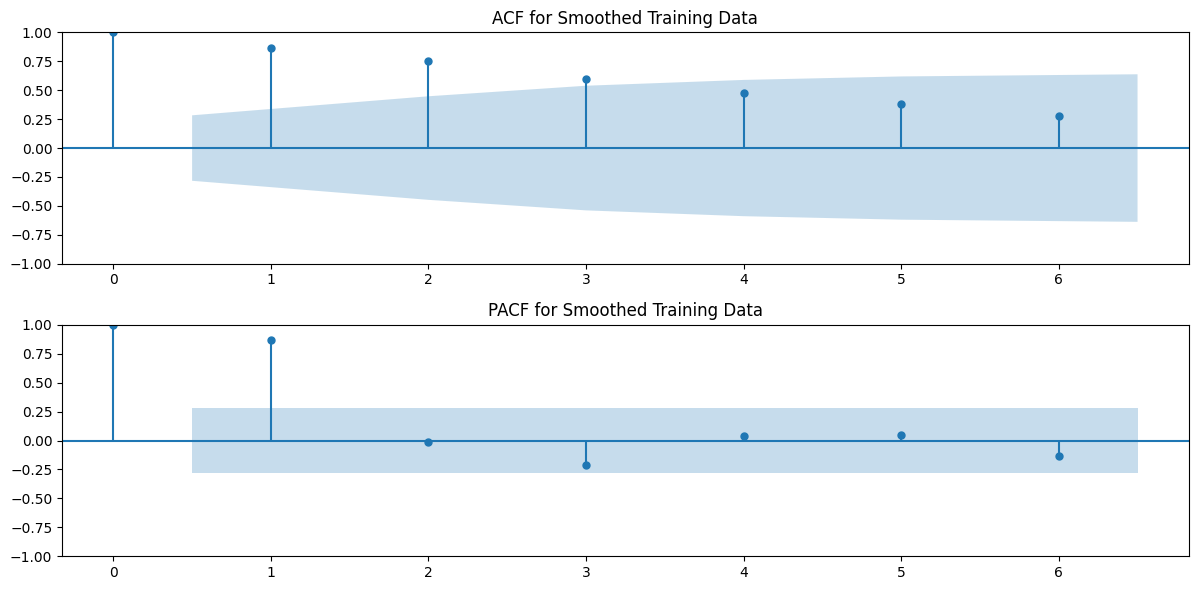

Recommended Moving Average (MA) Lag (from ACF): 1
Recommended Autoregressive (AR) Lag (from PACF): 1


In [7]:
# @title Calculate ACF and PACF
# (ACF) The Autocorrelation Function describes the correlation between observations
# of a time series at two points in time, separated by a specific lag k.
# Essentially, it quantifies how a value in the time series is related to its previous values.
# (PACF) While the ACF measures the correlation between two points with a given lag,
# it doesn’t account for the influence of other intervening observations.
# The PACF remedies this by measuring the correlation between two points,
# controlling for the values at all shorter lags.
# Set the number of lags to check
nlags = 6
# ACF
acf_values, confint_acf = acf(train_data['y'], alpha=0.05, nlags=nlags)
# PACF
pacf_values, confint_pacf = pacf(train_data['y'], alpha=0.05, nlags=nlags)
# Plot ACF and PACF
plt.figure(figsize=(12, 6))
# Plot ACF
plt.subplot(211)
plot_acf(train_data['y'], ax=plt.gca(), lags=nlags)
plt.title('ACF for Smoothed Training Data')
# Plot PACF
plt.subplot(212)
plot_pacf(train_data['y'], ax=plt.gca(), lags=nlags)
plt.title('PACF for Smoothed Training Data')
# Show
plt.tight_layout()
plt.show()
# Find recommended lags programmatically
# Find the first lag where the ACF value is within the confidence interval (for MA term)
upper_confidence_bound_acf = confint_acf[:, 1]
recommended_ma_lag = np.where(acf_values < upper_confidence_bound_acf)[0][0]
# Find the first lag where the PACF value is within the confidence interval (for AR term)
upper_confidence_bound_pacf = confint_pacf[:, 1]
recommended_ar_lag = np.where(pacf_values < upper_confidence_bound_pacf)[0][0]
print(f"Recommended Moving Average (MA) Lag (from ACF): {recommended_ma_lag}")
print(f"Recommended Autoregressive (AR) Lag (from PACF): {recommended_ar_lag}")

In [8]:
# @title Scaling Training and Test Data
def scale_data(train_data, test_data):
    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train_data.values.reshape(-1, 1))
    test_scaled = scaler.transform(test_data.values.reshape(-1, 1))
    return train_scaled, test_scaled
train_data['y'], test_data['y'] = scale_data(train_data['y'], test_data['y'])
# Metrics
print(f"Training Data Shape: {train_data.shape}")
print(f"Testing Data Shape: {test_data.shape}")
print(f"\nSample Training Data (Scaled):\n", train_data['y'].head())
print(f"\nSample Test Data (Scaled):\n", test_data['y'].head())
# Convert scaled data back to DataFrame for SARIMA
train_data_scaled = pd.DataFrame(train_data['y'], index=train_data.index, columns=['y'])
test_data_scaled = pd.DataFrame(test_data['y'], index=test_data.index, columns=['y'])
# Combine scaled train and test data
data_scaled = pd.concat([train_data_scaled, test_data_scaled])

Training Data Shape: (48, 10)
Testing Data Shape: (12, 10)

Sample Training Data (Scaled):
 date
2019-01    0.897604
2019-02    0.635036
2019-03    0.509881
2019-04    0.434359
2019-05    0.628513
Freq: M, Name: y, dtype: float64

Sample Test Data (Scaled):
 date
2023-01    0.902902
2023-02    0.778862
2023-03    1.024315
2023-04    0.936015
2023-05    1.062158
Freq: M, Name: y, dtype: float64


In [9]:
# @title SARIMA Model
# SARIMA model fitting and forecasting
def model_sarima(train_data, step_size, p, d, q, P, D, Q, s):
    model = SARIMAX(train_data, order=(p, d, q), seasonal_order=(P, D, Q, s))
    model_fit = model.fit(disp=False)
    prediction = model_fit.forecast(steps=step_size)
    return prediction, model_fit
# Cross-validation for SARIMA
def sarima(data, feature_name, initial_window_size, step_size, p, d, q, P, D, Q, s):
    window_size = initial_window_size
    predictions = pd.Series(dtype='float64', index=data.index)
    # Sliding window approach for time series cross-validation
    while window_size + step_size <= len(data):
        train_data = data[feature_name][:window_size]
        test_data = data[feature_name][window_size:window_size + step_size]
        # prediction
        prediction, model_fit = model_sarima(train_data, step_size, p, d, q, P, D, Q, s)
        prediction.index = test_data.index
        predictions[test_data.index] = prediction
        window_size += step_size
    return data[feature_name][initial_window_size:], predictions[initial_window_size:], model_fit

In [10]:
# @title Model Evaluation
parameter_sets = [
    # {'p': 1, 'd': 0, 'q': 0, 'P': 1, 'D': 0, 'Q': 0, 's': 12},
    # {'p': 1, 'd': 1, 'q': 1, 'P': 1, 'D': 0, 'Q': 1, 's': 12},
    # {'p': 1, 'd': 1, 'q': 0, 'P': 1, 'D': 1, 'Q': 0, 's': 12},
    # {'p': 1, 'd': 1, 'q': 0, 'P': 1, 'D': 0, 'Q': 0, 's': 12},
    # {'p': 1, 'd': 0, 'q': 1, 'P': 1, 'D': 0, 'Q': 1, 's': 12},
    # {'p': 1, 'd': 0, 'q': 0, 'P': 1, 'D': 1, 'Q': 0, 's': 12},
    # {'p': 2, 'd': 0, 'q': 0, 'P': 2, 'D': 0, 'Q': 0, 's': 12},
    {'p': 2, 'd': 1, 'q': 0, 'P': 1, 'D': 0, 'Q': 0, 's': 12},
    # {'p': 2, 'd': 1, 'q': 0, 'P': 1, 'D': 1, 'Q': 0, 's': 12},
    # {'p': 2, 'd': 1, 'q': 0, 'P': 2, 'D': 1, 'Q': 0, 's': 12},
]
# Cross-validation: Test different parameter sets and plot results
for params in parameter_sets:
    test, forecast, model = sarima(
        data_scaled,
        'y',
        initial_window_size=48,
        step_size=1,
        p=params['p'],
        d=params['d'],
        q=params['q'],
        P=params['P'],
        D=params['D'],
        Q=params['Q'],
        s=params['s']
    )
    # Remove any NaN values in test and forecast
    test = test.dropna()
    forecast = forecast.dropna()
    # Align the indices of the test and forecast data
    test, forecast = test.align(forecast, join='inner')
    # Print params
    print(f"Params: {params}")
    # Check if test or forecast is empty
    if test.empty or forecast.empty:
        print("Test or forecast data is empty after aligning indices.")
        continue
    # Calculate evaluation metrics
    def mean_absolute_percentage_error(y_true, y_pred):
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    bic = model.bic  # Extract the BIC from the fitted SARIMA model
    mse = mean_squared_error(test, forecast)
    mae = mean_absolute_error(test, forecast)
    r2 = r2_score(test, forecast)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(test, forecast)
    msle = mean_squared_log_error(test, forecast)
    residuals = test - forecast
    lb_test = acorr_ljungbox(residuals, lags=[6], return_df=True)['lb_pvalue'].values[0]
    # Print metrics
    # Average magnitude of errors in predictions, without considering their direction
    print(f'MAE: {mae}') # Indicates average absolute error
    # Average difference between a statistical model's predicted values and the actual values
    print(f'RMSE: {rmse}') # Penalizes large errors more
    # Prediction accuracy of a forecasting method in statistics
    print(f'MAPE: {mape}') # Useful to report the error in percentage terms
    # Coefficient of determination, the proportion of variance in a dependent variable that can be predicted or explained by an independent variable
    print(f'R²: {r2}') # For explaining how much variance the model captures
    # Bayesian Information Criterion: evaluates how well the model fits the data relative to its complexity
    print(f'BIC: {bic}') # For balancing fit vs. complexity
    # Average of the squares of the errors
    print(f'MSE: {mse}')
    # Average of the squared differences between the logarithms of the predicted and actual values
    print(f'MSLE: {msle}')
    # High p-value (> 0.05): No significant autocorrelation in residuals, meaning the model is good at capturing the data structure
    print(f'Ljung-Box Test p-value: {lb_test}\n') # To confirm the residuals have no significant autocorrelation
    # Interactive Plot using Plotly
    training_data = data_scaled['y'][:train_size]
    testing_data = test
    forecast_data = forecast
    train_idx = train_data.index.to_timestamp()
    test_idx = test_data.index.to_timestamp()
    forecast_idx = test_data.index.to_timestamp()
    # Plot using Plotly
    fig = go.Figure()
    # Training data
    fig.add_trace(go.Scatter(x=train_idx, y=training_data, mode='lines', name='Training Data'))
    # Testing data
    fig.add_trace(go.Scatter(x=test_idx, y=testing_data, mode='lines', name='Testing Data'))
    # Forecast data
    fig.add_trace(go.Scatter(x=forecast_idx, y=forecast_data, mode='lines', name='Forecast'))
    # Add titles and labels
    fig.update_layout(
        title=f"SARIMA Forecast vs Actual (Params: {params})",
        xaxis_title='Date',
        yaxis_title='Scaled Values',
        legend_title='Legend',
        hovermode='x'
    )
    # Show the interactive plot
    fig.show()

Params: {'p': 2, 'd': 1, 'q': 0, 'P': 1, 'D': 0, 'Q': 0, 's': 12}
MAE: 0.14009248725186005
RMSE: 0.16612626237890146
MAPE: 21.76255893855833
R²: 0.6595810160527764
BIC: -53.56408522571972
MSE: 0.027597935051983616
MSLE: 0.008681576017470695
Ljung-Box Test p-value: 0.09336969082888837

